In [2]:
import datetime as dt

import numpy as np
from scipy import stats
import pandas as pd

from lmax_analytics_notebooks.environment.get_creds import get_creds
from lmax_analytics_notebooks.environment.get_env import get_env
from lmax_analytics.dataloader.backtesting_dataloader import BacktestingLoader

Loading BokehJS ...

In [3]:
## ENVIRONMENT VARIABLES
server = 'blue'
bucket = 'backtesting-output'
base_prefix = 'backtesting/simulation_outputs'

In [4]:
creds = get_creds(file="../auth/credentials.yaml")
env = get_env(creds['environment'])

In [5]:
s3 = env.get_boto3_resource(server=server, key=creds['minio']['key'], secret=creds['minio']['secret'])
fs = env.get_s3fs(server=server, key=creds['minio']['key'], secret=creds['minio']['secret'])
bl = BacktestingLoader(boto3_fs=s3)

In [6]:
def f(x):
    d = {}

    d['sample_days'] = int(x['trading_session'].unique().__len__())
    d['rpnl_mu'] = round(x['rpnl'].mean(), 2)
    d['rpnl_std'] = round(x['rpnl'].std(), 2)
    d['rpnl_95%_thres'] = (
        round(x['rpnl'].mean() - (x['rpnl'].std() * 2), 2), round(x['rpnl'].mean() + (x['rpnl'].std() * 2), 2))

    if int(x['trading_session'].unique().__len__()) > 30:
        z = stats.norm.ppf(.975)
        var = z * x['rpnl'].std() / np.sqrt(int(x['trading_session'].unique().__len__()))
        low_end = x['rpnl'].mean() - var
        high_end = x['rpnl'].mean() + var
        d['rpnl_95%_conf'] = (round(low_end, 2), round(high_end, 2))
    else:
        confidence = 0.95
        n = int(x['trading_session'].unique().__len__())
        ddof = n - 1
        m = x['rpnl'].mean()
        std_err = x['rpnl'].std() / np.sqrt(n)
        t_score = stats.t.ppf((1 + confidence) / 2, ddof)
        h = std_err * t_score
        start = m - h
        end = m + h
        d['rpnl_95%_conf'] = (round(start, 2), round(end, 2))

    d['trade_cnt_mu'] = round(x['trade_cnt'].mean(), 0)
    d['wt_net_qty_mu'] = round(x['net_qty'].mean(), 2)

    if 'rpnl_sum_SL_close_position' in x.columns:
        d['SL_rpnl_mu'] = round(np.mean(x['rpnl_sum_SL_close_position']), 2)
        d['SL_cnt_mu'] = round(np.mean(x['rpnl_count_SL_close_position']), 0)

    if 'rpnl_sum_TP_close_position' in x.columns:
        d['TP_rpnl_mu'] = round(np.mean(x['rpnl_sum_TP_close_position']), 2)
        d['TP_cnt_mu'] = round(np.mean(x['rpnl_count_TP_close_position']), 0)

    if all(i in x.columns for i in ['rpnl_sum_SL_close_position', 'rpnl_sum_TP_close_position']):
        d['hedged_rpnl_mu'] = round(np.mean(x['rpnl_sum_SL_close_position'] + x['rpnl_sum_TP_close_position']), 2)
        d['hedged_cnt_mu'] = round(np.mean(x['rpnl_count_SL_close_position'] + x['rpnl_count_TP_close_position']), 0)

    d['internalised_rpnl_mu'] = round(
        np.mean(x['rpnl_sum_client_long_open_short'] + x['rpnl_count_client_short_open_long']), 2)

    d['internalised_cnt_mu'] = round(
        np.mean(x['rpnl_count_client_long_open_short'] + x['rpnl_count_client_short_open_long'], 0))
    return pd.Series(d, index=list(d.keys()))

In [7]:
## CURRENT DEPLOYED BACKTESTING SCENARIOS

scenarios = {
    "ldprof_internalisation_parameter_tuning_lite_tight_symbols": {'uid': 'ld-int-tight-pt', 'version': 1}}


In [8]:
### SELECT A SCENARIO YOU WANT TO RETRIEVE

In [9]:
scenario = scenarios["ldprof_internalisation_parameter_tuning_lite_tight_symbols"]

In [10]:
### LOAD BACKTESTS FOR DATE RANGE AND INSTRUMENT

In [11]:
shard = 'ldprof'
start_date = dt.date(2020,10,1)
end_date = dt.date(2020,11,18)
instruments = None#[100645]

In [12]:
%%time
df = bl.load_sims_s3(bucket, base_prefix, shard, scenario['uid'], str(scenario['version']), start_date, end_date, instruments=instruments)

CPU times: user 2.05 s, sys: 443 ms, total: 2.49 s
Wall time: 3.99 s


In [13]:
### LIST OF SYMBOLS FOR THIS SCENARIO

In [14]:
df[['symbol', 'order_book_id']].drop_duplicates()

,symbol,order_book_id
0,NZD/USD,100741
0,USD/JPY,100643
1,GBP/JPY,100645
3,EUR/JPY,100647
4,AUD/USD,100649
5,USD/CHF,100655
6,USD/CAD,100661
7,EUR/USD,100637
8,GBP/USD,100639


In [15]:
### VIEW RESULTS OF BACKTESTING

In [16]:
order_book_id = 100643

In [17]:
df_subset = df[df.order_book_id==order_book_id]

In [18]:
df_summary = df_subset.groupby([x for x in ['hash', 'symbol', 'exit_name', 'strategy_max_pos_qty', 'exit_stoploss_limit', 'exit_takeprofit_limit', 'event_filter_string', 'simulation'] if x in df.columns]).apply(f)

In [19]:
df_summary.nlargest(10, 'rpnl_mu')

,,,,,,,sample_days,rpnl_mu,rpnl_std,rpnl_95%_thres,rpnl_95%_conf,trade_cnt_mu,wt_net_qty_mu,SL_rpnl_mu,SL_cnt_mu,TP_rpnl_mu,TP_cnt_mu,hedged_rpnl_mu,hedged_cnt_mu,internalised_rpnl_mu,internalised_cnt_mu
hash,symbol,exit_name,strategy_max_pos_qty,exit_stoploss_limit,exit_takeprofit_limit,simulation,,,,,,,,,,,,,,,
1cd041fa974d4ee93e08e1373bdef70b,USD/JPY,aggressive,50,200,25.0,liquid_pairs_aggressive,26,-323.01,927.91,"(-2178.83, 1532.8)","(-697.8, 51.78)",2158.0,6.27,-994.15,1.0,2608.51,42.0,4504.08,128.0,-490.23,2112.0
d46775909270ad3ff15f544b249b4a16,USD/JPY,profit_running,50,200,25.0,liquid_pairs_profit_running,26,-327.46,913.79,"(-2155.03, 1500.11)","(-696.55, 41.63)",2152.0,6.03,-1062.47,2.0,2038.60,43.0,3772.37,137.0,-230.57,2106.0
4b20ad2fde0ea0e226204180c37ee866,USD/JPY,aggressive,50,150,25.0,liquid_pairs_aggressive,26,-375.69,962.36,"(-2300.41, 1549.02)","(-764.4, 13.01)",2160.0,6.26,-1549.33,2.0,2612.08,42.0,1843.17,73.0,-394.57,2112.0
469786bb7f1b3a249e1c7a61f48336ff,USD/JPY,aggressive,50,200,50.0,liquid_pairs_aggressive,26,-409.28,1110.10,"(-2629.49, 1810.92)","(-857.66, 39.1)",2108.0,6.50,-1155.46,1.0,2309.00,13.0,3668.02,38.0,-400.78,2087.0
76181d5df45d8888d17af95ac2b3a8dd,USD/JPY,profit_running,50,150,25.0,liquid_pairs_profit_running,26,-412.94,938.80,"(-2290.53, 1464.66)","(-792.13, -33.75)",2155.0,5.90,-969.75,2.0,2048.38,44.0,1702.25,70.0,-115.56,2106.0
fe93164fc5080290f573bff7dfe157ca,USD/JPY,profit_running,50,100,25.0,liquid_pairs_profit_running,26,-428.41,1058.77,"(-2545.95, 1689.14)","(-856.06, -0.76)",2168.0,5.51,-1359.90,5.0,2165.23,50.0,934.13,58.0,217.62,2111.0
d711ff22eddd6f763b9e0e070ac913d5,USD/JPY,profit_running,50,200,50.0,liquid_pairs_profit_running,26,-434.81,1072.18,"(-2579.18, 1709.56)","(-867.87, -1.74)",2101.0,7.04,-1037.00,2.0,1544.07,14.0,2389.85,35.0,-26.35,2081.0
73cfebe6d876b4ca65db49a23b309c2e,USD/JPY,profit_running,50,150,50.0,liquid_pairs_profit_running,26,-469.44,1120.20,"(-2709.84, 1770.96)","(-921.9, -16.98)",2104.0,6.67,-1325.08,2.0,1566.06,14.0,848.16,24.0,152.40,2083.0
b984d58c581e717f522412741dbd51f9,USD/JPY,aggressive,50,150,50.0,liquid_pairs_aggressive,26,-479.08,1096.92,"(-2672.91, 1714.76)","(-922.13, -36.02)",2111.0,6.42,-1296.64,2.0,2307.99,14.0,1320.52,19.0,-220.96,2089.0


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [21]:
### DISTRIBUTION OF ALL SIMULATIONS BY EXIT TYPE AND LINEPLOT OF DAILY INDEPENDENT PERFORMANCE

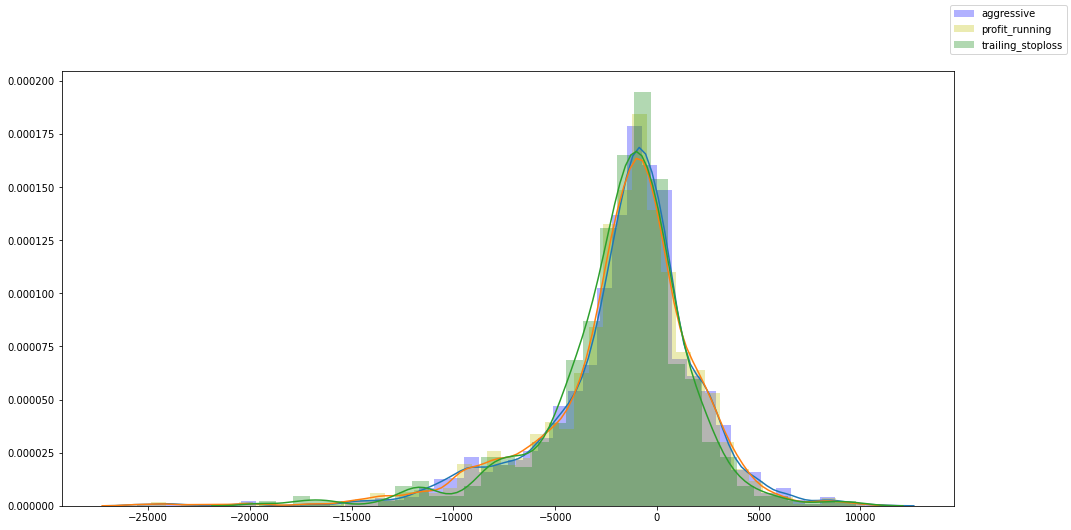

In [22]:
exits = df_subset.exit_name.unique().tolist()

fig = plt.figure(figsize=(16,8))

for (exit, colour) in zip(exits, ['b', 'y', 'g']):
    df_exit = df_subset[df_subset.exit_name==exit]
    daily_rpnl = df_exit['rpnl'].values
    sns.distplot(daily_rpnl, hist_kws={"alpha": 0.3, "color":colour})

fig.legend(labels=exits)
plt.show()

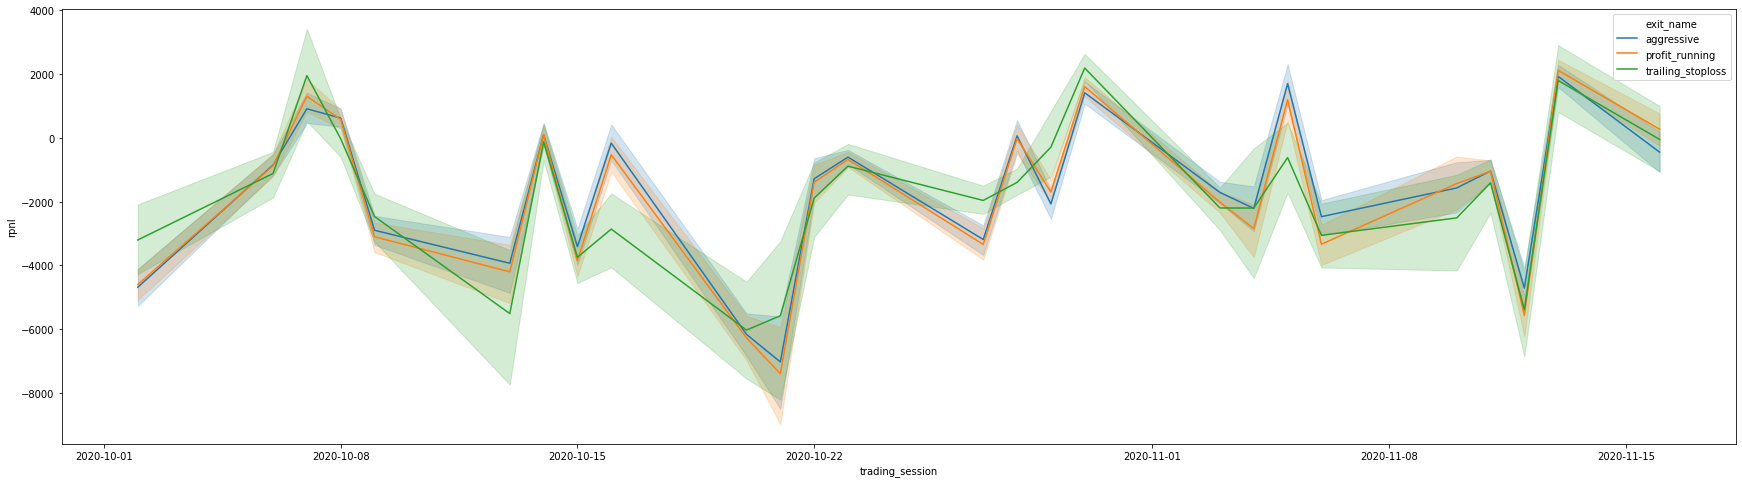

In [23]:
fig = plt.figure(figsize=(30,8))
sns.lineplot(data=df_subset, x="trading_session", y="rpnl", hue="exit_name")
plt.show()

In [24]:
### DISTRIBUTION OF A SIMULATION HASH AND LINEPLOT OF DAILY INDEPENDENT PERFORMANCE

In [25]:
_hash = '469786bb7f1b3a249e1c7a61f48336ff'

In [26]:
df_hash = df_subset[df_subset.hash==_hash]
daily_rpnl = df_hash['rpnl'].values

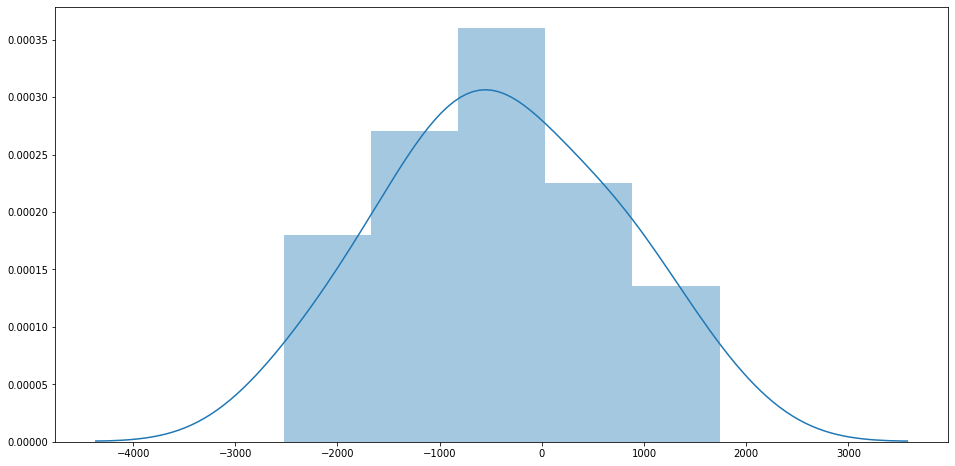

In [27]:
plt.figure(figsize=(16,8))
sns.distplot(daily_rpnl)

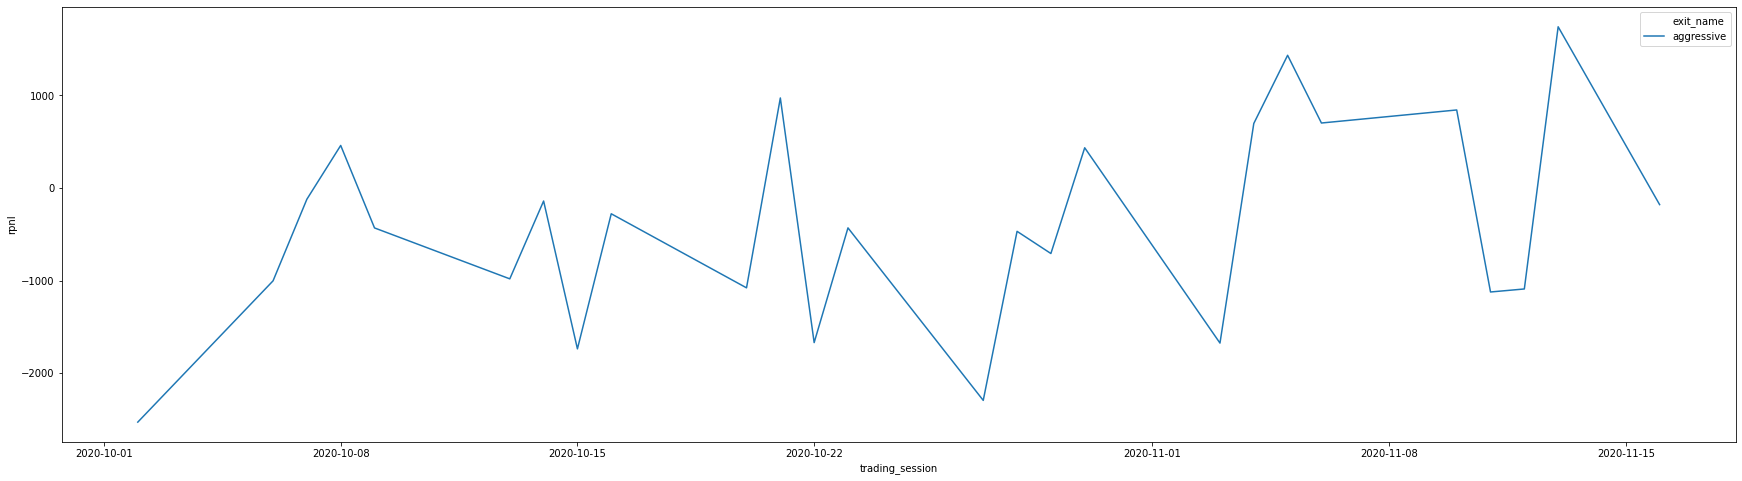

In [28]:
fig = plt.figure(figsize=(30,8))
sns.lineplot(data=df_hash, x="trading_session", y="rpnl", hue="exit_name")
plt.show()